<h1> Real and Fake news classification with BERT

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

#### Path del dataset di train ####
train_path = "/content/drive/MyDrive/Progetti data science/Progetto Python/BERT/dataset/Fake_News_train.csv"

#### Path per salvare il modello ####
model_save_path = "/content/drive/MyDrive/Progetti data science/Progetto Python/BERT/BERT_base_uncased_16_batch_size"

#### Path del dataset di test ####
test_path = "/content/drive/MyDrive/Progetti data science/Progetto Python/BERT/dataset/REAL_and_FAKE_news_dataset_test.csv"

Mounted at /content/drive/


# Import

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
import nltk
import re
import itertools
from tabulate import tabulate
from tqdm import trange
from collections import Counter

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Shuffle Data
def shuffle(df, n=3, axis=0):     
    df = df.copy()
    random_states = [2,42,4]
    for i in range(n):
        df = df.sample(frac=1,random_state=random_states[i]) # mischio il dataframe 
    return df

def clean_text(text):
    
    # removing URLs 
    text = re.sub(r"http\S+", "",text) 
    
    # removing html tags
    html=re.compile(r'<.*?>') 
    text = html.sub(r'',text) 
    
    # replacing everything with space except (a-z, A-Z)
    text = re.sub(r"[^a-zA-Z]+", " ", text) 
    
    # lower text
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    # removing stopwords
    text = " ".join(text) 

    # removing emoji 
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)
    return text

def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(texts) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(list(texts)[index])
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))
  
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
#verificare la disponibilità di cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))
print(device)

Tesla T4
cuda:0


# Model

## Pre-processing data

In [ ]:
df = pd.read_csv(train_path)

df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
drop_columns = ['id', 'title', 'author']
df = df.drop(drop_columns, axis=1)

df

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Ever get the feeling your life circles the rou...,0
2,"Why the Truth Might Get You Fired October 29, ...",1
3,Videos 15 Civilians Killed In Single US Airstr...,1
4,Print \nAn Iranian woman has been sentenced to...,1
...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,0
20796,When the Green Bay Packers lost to the Washing...,0
20797,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
# conteggio valori nulli
df.isnull().sum()

text     39
label     0
dtype: int64

<h3>Conteggio delle righe con campo 'text' duplicato e/o nullo, ed eliminazione delle stesse

In [ ]:
Counter(df['text'].duplicated())

Counter({False: 20387, True: 413})

In [ ]:
df = df.drop_duplicates('text',keep='first')
df = df.dropna()

In [ ]:
# reset dell'indice
df = df.reset_index()

df

,index,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,Ever get the feeling your life circles the rou...,0
2,2,"Why the Truth Might Get You Fired October 29, ...",1
3,3,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...
20381,20795,Rapper T. I. unloaded on black celebrities who...,0
20382,20796,When the Green Bay Packers lost to the Washing...,0
20383,20797,The Macy’s of today grew from the union of sev...,0
20384,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
# conteggio elementi per ogni classe
Counter(df.label)

Counter({1: 9999, 0: 10387})

In [ ]:
df = shuffle(df)

df.head(20)

,index,text,label
3045,3077,Russia did not let Turkish planes enter Syrian...,1
13992,14240,Iowa Berniecrat Chris Schwartz Claims That H...,1
16566,16870,"By 2050, the world’s population is estimated t...",1
10173,10341,"VIDEO : Ted Cruz STUMPS for TRUMP, “There’s No...",1
17027,17350,If you’re among the tens of millions of people...,0
3167,3199,Spetsnaz GRU: Russian special operations force...,1
18536,18902,BNI Store Nov 2 2016 ARIZONA Charter School te...,1
19942,20342,You are here: Home / *Articles of the Bound* /...,1
20092,20497,"Thursday, 27 October 2016 Biden and Trump to D...",1
14762,15028,Media Spin: The FBI's Actions Are Deeply Troub...,1


## Deleting stopwords

In [ ]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

df['text']

3045     russia let turkish planes enter syrian airspac...
13992    iowa berniecrat chris schwartz claims house va...
16566    world population estimated reach billion peopl...
10173    video ted cruz stumps trump division unity vid...
17027    among tens millions people affected winter sto...
                               ...                        
5965     nation capital planning use help migrants circ...
8032     year much public scrutiny exxon mobil captured...
16762    cruelty us economic sanctions november propaga...
7230     pigeon forge tenn deadly wildfires ripped foot...
15612    muslim working islamist blogging website syria...
Name: text, Length: 20386, dtype: object

In [ ]:
texts = df.text
labels = list(df.label)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### Esempio di tokenizzazione

In [ ]:
index = 0
print(' Original: ', list(texts)[index])

table = np.array([tokenizer.tokenize(list(texts)[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(list(texts)[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))

 Original:  russia let turkish planes enter syrian airspace source ap photo turkish aircraft tried enter syrian airspace north province aleppo turn back warning syrian russian forces source securety services told sputnik news agency august turkish army launched operation euphrates shield islamic state terrorist group banned russia participation syrian opposition military took control border town jarabulus northern syria continued offensive south west according turkish president tayyip erdogan goal offensive exterminate terrorists territory square kilometres create safety zone accommodate refugees northern syria turkish troops regularly come clashes forces kurdish militia consider related kurdistan workers party however official damascus shares different opinion subject syrian authorities estimate presence turkish army territory syria violation sovereignty country could escalate conflict middle east turned largest global puzzle pieces never come together original pattern pravda ru read 

### Add special tokens

In [ ]:
l = []
max_len = 0

for sent in list(texts):

    # Divide il testo in token e aggiungi i token speciali [CLS] e [SEP].
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Aggiorna la lunghezza massima della frase
    l.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
    
# controllo lunghezza
if max_len>512:
  max_len=512

avg_len=int(sum(l)/len(l))

print('Max sentence length: ', max_len)
print('Avg sentence length: ', avg_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  512
Avg sentence length:  485


In [ ]:
# Tokenizzare tutte le frasi e mappare i token ai loro ID di parola.Tokenizzare tutte le frasi e mappare i token ai loro ID di parola.
input_ids = []
attention_masks = []

for sent in texts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                               # Sentence to encode.
                        add_special_tokens = True,          # Add '[CLS]' and '[SEP]'
                        truncation=True, 
                        truncation_strategy='only_first',   #prende le parole nel mezzo
                        max_length = 128,               # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,       # Construct attn. masks.
                        return_tensors = 'pt'              # Return pytorch tensors.
                   )
    
    # Aggiungi la frase codificata alla lista   
    input_ids.append(encoded_dict['input_ids'])
    
    # attention mask distingue il padding dal non padding
    attention_masks.append(encoded_dict['attention_mask'])

# Converte la lista in tensori.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

### Esempio di Encoding

In [ ]:
# Stampa la frase 0 come una lista di ID
i=random.randint(0,len(texts)-1)
print('Original: ', list(texts)[i])
print('Input IDs:', input_ids[i])

Original:  governments lie
Input IDs: tensor([ 101, 6867, 4682,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])


In [ ]:
print_rand_sentence_encoding()

gardasil vaccine given without consent ruins life year old girl savannah mother sarah snyder health impact news vaxxed film crew continues interviewing people vaccine damaged around country interview nebraska year old savannah snyder interviewed along mother sarah savannah talks experiences receiving th grade required vaccines mother sarah explains gave permission savannah receive required vaccines gardasil hpv vaccine optional vaccine sarah explains warned vaccine wanted investigate believe doctor every parent believes doctor trying right thing savannah given gardasil vaccine anyway without original knowledge immediately started suffering side effects headache almost fainting skin rashes breaking soon developed pneumonia infections time went things got worse started experiencing seizures including grand mal seizures hospitalized many times severe pain mother tearfully explains savannah would wake middle night state dying like many parents children gardasil injuries sarah relates littl

## Train e validation set

In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

16,308 training samples
4,078 validation samples


The optimal hyperparameter values are task-specific, but we found the following range of possible values to work well across all tasks:

- Batch size: 16, 32

- Learning rate (Adam): 5e-5, 3e-5, 2e-5

- Number of epochs: 2, 3, 4

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.

batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## BERT model creation

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8) # defaults are 2e-5 for lr, 1e-8 for eps

### Fine tuning

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)  
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value;                           
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch time: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    #save the best model
    if avg_val_accuracy < best_eval_accuracy:
        torch.save(model, model_save_path)
        best_eval_accuracy = avg_val_accuracy

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation time: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("Training complete!")
print("Total training time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 0.23
  Training epoch time: 0:06:01

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.14
  Validation time: 0:00:29

======== Epoch 2 / 4 ========
Training...

  Average training loss: 0.09
  Training epoch time: 0:06:04

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.17
  Validation time: 0:00:29

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.04
  Training epoch time: 0:06:05

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.15
  Validation time: 0:00:29

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.01
  Training epoch time: 0:06:03

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.18
  Validation time: 0:00:29
Training complete!
Total training time 0:26:27 (h:mm:ss)


## Evaluating model on train set

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.23,0.14,0.96,0:06:01,0:00:29
2,0.09,0.17,0.96,0:06:04,0:00:29
3,0.04,0.15,0.97,0:06:05,0:00:29
4,0.01,0.18,0.97,0:06:03,0:00:29


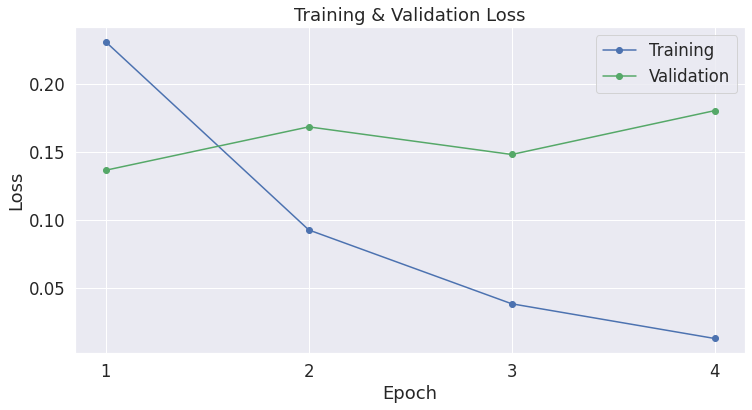

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

An **underfit** model can be identified from the learning curve of the training loss only.

It may show a flat line or noisy values of relatively high loss, indicating that the model was unable to learn the training dataset at all.

An example of this is provided below and is common when the model does not have a suitable capacity for the complexity of the dataset.

A plot of learning curves shows **underfitting** if:

- The training loss remains flat regardless of training.
- The training loss continues to decrease until the end of training.

A plot of learning curves shows **overfitting** if:

- The plot of training loss continues to decrease with experience.
- The plot of validation loss decreases to a point and begins increasing again.

A plot of learning curves shows a **good** fit if:

- The plot of training loss decreases to a point of stability.
- The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

# Inference

<h2> Controllare che siano presenti **almeno** due colonne: 

1.   text: contiene il testo che andrà in input al classificatore
2.   label: 0 indica che la notizia è vera, 1 che è fake


In [ ]:
# Caricamento modello BERT
model = torch.load(model_save_path)

## Pre-processing test set

In [ ]:
df_test = pd.read_csv(test_path)

df_test

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [ ]:
# mapping labels
df_test['label'] = df_test['label'].map({'FAKE':1,'REAL':0})

df_test

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,0
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,1
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",0


### Deleting stopwords

In [ ]:
df_test['text'] = df_test['text'].apply(lambda x: clean_text(x))

df_test['text']

0       daniel greenfield shillman journalism fellow f...
1       google pinterest digg linkedin reddit stumbleu...
2       u secretary state john f kerry said monday sto...
3       kaydee king kaydeeking november lesson tonight...
4       primary day new york front runners hillary cli...
                              ...                        
6330    state department told republican national comm...
6331    p pbs stand plutocratic pentagon posted oct wi...
6332    anti trump protesters tools oligarchy reform a...
6333    addis ababa ethiopia president obama convened ...
6334    jeb bush suddenly attacking trump matters jeb ...
Name: text, Length: 6335, dtype: object

In [ ]:
# Create sentence and label lists
texts = df_test.text.values
labels = df_test.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# For every sentence...
for sent in texts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                             # Sentence to encode.
                        add_special_tokens = True,        # Add '[CLS]' and '[SEP]'
                        truncation=True, 
                        truncation_strategy='only_first',
                        max_length = 128,             # Pad & truncate all sentences.
                        padding='max_length',
                        return_attention_mask = True,     # Construct attn. masks.
                        return_tensors = 'pt',            # Return pytorch tensors.
                   )

    
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Test and metrics

### Prediction

In [ ]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 6,335 test sentences...
    DONE.


### Accuracy, precision, recall e F1 score

In [ ]:
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

# accuracy
accuracy = accuracy_score(scores, labels)
print('Accuracy: {:.2f}'.format(accuracy))

# precision
precision = precision_score(labels, scores)
print('Precision: {:.2f}'.format(precision))

# recall
recall = recall_score(labels, scores)
print('Recall: {:.2f}'.format(recall))

# F1 score
f1 = f1_score(labels, scores)
print('F1 Score: {:.2f}'.format(f1))

Accuracy: 0.84
Precision: 0.76
Recall: 0.99
F1 Score: 0.86


### Confusion Matrix

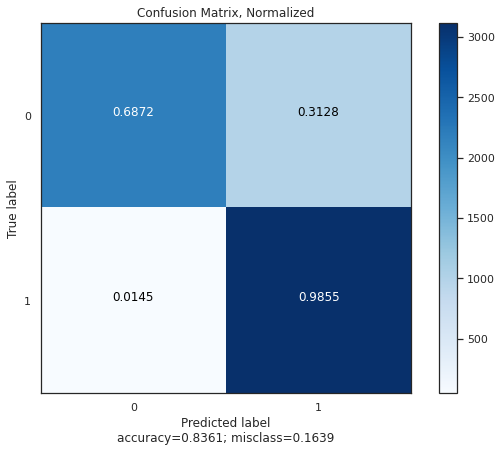

In [ ]:
sns.set(font_scale=1)
sns.set(style='white')

cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix, Normalized")

### ROC and AUC curve

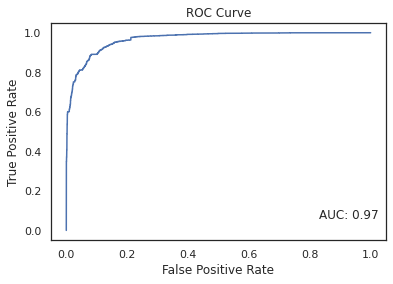

In [ ]:
# Unpack predictions and true labels
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Get ROC AUC score
roc_auc = roc_auc_score(true_labels, predictions[:, 1])
fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve') #Print AUC value on the plot
plt.annotate('AUC: {:.2f}'.format(roc_auc), xy=(0.8, 0.1), xycoords='axes fraction')
plt.show()